In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
main_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
dataset_path = os.listdir(main_path)
classes = []
for foldername in dataset_path:
    folder_images = os.listdir(main_path + '/' + foldername)
    x = 0
    for image in folder_images:
        classes.append((foldername,str(main_path+'/'+foldername)+'/'+image)) #⚠️key
        x+=1
    print(x)


891
266
421


In [3]:
dataset_path

['benign', 'normal', 'malignant']

In [4]:
np.array(classes).shape

(1578, 2)

In [5]:
df = pd.DataFrame(classes, columns=['labels','images'])
df.head()

,labels,images
0,benign,/kaggle/input/breast-ultrasound-images-dataset...
1,benign,/kaggle/input/breast-ultrasound-images-dataset...
2,benign,/kaggle/input/breast-ultrasound-images-dataset...
3,benign,/kaggle/input/breast-ultrasound-images-dataset...
4,benign,/kaggle/input/breast-ultrasound-images-dataset...


In [6]:
df['labels'].value_counts()

labels
benign       891
malignant    421
normal       266
Name: count, dtype: int64

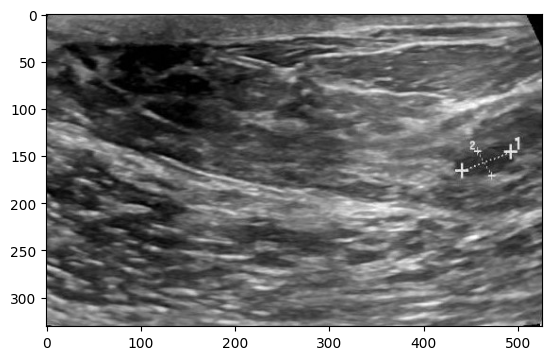

In [7]:
img = cv2.imread(df['images'][15])
plt.imshow(img)

In [8]:
r_images = []
r_labels = []
for index,value in enumerate(df['images']):
    img = cv2.imread(value)
    img = cv2.resize(img,(320,320))
    r_images.append(img)
    r_labels.append(df['labels'][index])

In [9]:
r_images = np.array(r_images)
r_images = r_images.astype('float32')/255.0

In [10]:
r_images.shape

(1578, 320, 320, 3)

In [11]:
df_new = pd.DataFrame(r_labels,columns=['Labels'])
df_new['Images'] = r_images

In [12]:
y = df_new['Labels'].values
print(set(y))

labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
print(set(y))

{'normal', 'benign', 'malignant'}
{0, 1, 2}


In [13]:
Y = y.reshape(-1,1)
ct = ColumnTransformer([('ohe',OneHotEncoder(),[0])],remainder='passthrough')
Y = ct.fit_transform(Y)
Y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [14]:
sh_images,sh_Y = shuffle(r_images,Y,random_state=1)

In [15]:
x_train,x_test,y_train,y_test = train_test_split(sh_images,sh_Y,test_size=0.15,random_state=100)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1341, 320, 320, 3)
(1341, 3)
(237, 320, 320, 3)
(237, 3)


In [16]:
xception_base = keras.applications.Xception(include_top=False,input_shape=(320,320,3),classes=3)
ga_layer = keras.layers.GlobalAveragePooling2D()(xception_base.output)
output = keras.layers.Dense(3,activation='softmax')(ga_layer)
model = keras.Model(inputs = xception_base.input,outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


In [17]:
len(xception_base.layers)

132

# I have already tried multiple methods like training with pre_trained weights for which I got 91% val_accuracy with 26% of val_loss using adam.

In [18]:
for layer in xception_base.layers:
    layer.trainable = False

In [19]:
# for layer in xception_base.layers:
#     layer.trainable = True

In [20]:
# for layer in xception_base.layers[20:]:
#     layer.trainable = False

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 159, 159, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 159, 159, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [22]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.CategoricalCrossentropy()]) #⚠️if not one-hot ten sparse categorical crossentropy

In [23]:
callback = [tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True),
           tf.keras.callbacks.ModelCheckpoint(filepath='breas_C.h5',save_best_only=True)]


In [24]:
h = model.fit(x_train,y_train,epochs=100,validation_split=0.2,callbacks =callback )

Epoch 1/100
34/34 [==============================] - 20s 306ms/step - loss: 0.9208 - accuracy: 0.5485 - categorical_crossentropy: 0.9208 - val_loss: 0.7505 - val_accuracy: 0.6506 - val_categorical_crossentropy: 0.7505
Epoch 2/100
34/34 [==============================] - 7s 207ms/step - loss: 0.7215 - accuracy: 0.7192 - categorical_crossentropy: 0.7215 - val_loss: 0.6402 - val_accuracy: 0.7770 - val_categorical_crossentropy: 0.6402
Epoch 3/100
34/34 [==============================] - 7s 206ms/step - loss: 0.6231 - accuracy: 0.7593 - categorical_crossentropy: 0.6231 - val_loss: 0.5830 - val_accuracy: 0.7955 - val_categorical_crossentropy: 0.5830
Epoch 4/100
34/34 [==============================] - 7s 206ms/step - loss: 0.5684 - accuracy: 0.7743 - categorical_crossentropy: 0.5684 - val_loss: 0.5507 - val_accuracy: 0.8178 - val_categorical_crossentropy: 0.5507
Epoch 5/100
34/34 [==============================] - 7s 205ms/step - loss: 0.5312 - accuracy: 0.7892 - categorical_crossentropy: 0.

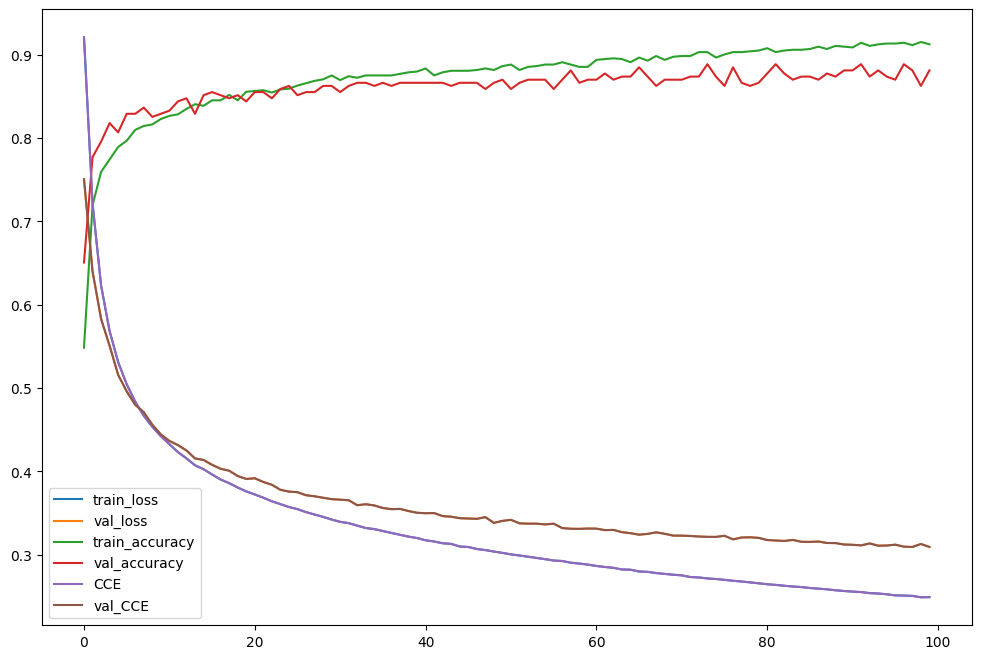

In [25]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(h.history['loss'],label='train_loss')
ax.plot(h.history['val_loss'],label='val_loss')
ax.plot(h.history['accuracy'],label='train_accuracy')
ax.plot(h.history['val_accuracy'],label='val_accuracy')
ax.plot(h.history['categorical_crossentropy'], label = 'CCE')
ax.plot(h.history['val_categorical_crossentropy'], label = 'val_CCE')
plt.legend()
fig.show()

In [26]:
y_pred = model.predict(x_test)


8/8 [==============================] - 2s 148ms/step


In [27]:
print(y_pred[:10])
print(y_test[:10])

[[9.3456835e-01 4.4903122e-02 2.0528497e-02]
 [8.9484537e-01 7.0682675e-02 3.4471966e-02]
 [7.9004198e-01 1.5321535e-01 5.6742709e-02]
 [2.5596104e-03 9.9659401e-01 8.4631151e-04]
 [9.0781249e-02 8.8563955e-01 2.3579177e-02]
 [8.7512100e-01 1.1964910e-01 5.2299332e-03]
 [9.9664259e-01 2.7791767e-03 5.7822926e-04]
 [3.8651624e-01 5.3089648e-01 8.2587302e-02]
 [1.2722662e-02 5.7111043e-03 9.8156619e-01]
 [9.7354871e-01 2.1197952e-02 5.2532437e-03]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [28]:
# y_pred = [np.argmax(i) for i in y_pred]
# y_test = [np.argmax(j) for j in y_test]
# accuracy_score(y_test,y_pred)

In [29]:
print(y_pred)

[[9.34568346e-01 4.49031219e-02 2.05284972e-02]
 [8.94845366e-01 7.06826746e-02 3.44719663e-02]
 [7.90041983e-01 1.53215349e-01 5.67427091e-02]
 [2.55961041e-03 9.96594012e-01 8.46311508e-04]
 [9.07812491e-02 8.85639548e-01 2.35791765e-02]
 [8.75120997e-01 1.19649097e-01 5.22993319e-03]
 [9.96642590e-01 2.77917669e-03 5.78229257e-04]
 [3.86516243e-01 5.30896485e-01 8.25873017e-02]
 [1.27226617e-02 5.71110426e-03 9.81566191e-01]
 [9.73548710e-01 2.11979523e-02 5.25324373e-03]
 [9.97973025e-01 1.76237221e-03 2.64527946e-04]
 [9.92763937e-01 6.57307031e-03 6.62965758e-04]
 [9.53165531e-01 4.60475683e-02 7.86911463e-04]
 [1.99761093e-01 7.83941269e-01 1.62976962e-02]
 [9.89181697e-01 1.00854868e-02 7.32866873e-04]
 [7.94647336e-01 9.96773764e-02 1.05675295e-01]
 [5.33905149e-01 4.42968369e-01 2.31265370e-02]
 [3.69910061e-01 1.72110014e-02 6.12878859e-01]
 [9.91858900e-01 6.68877084e-03 1.45236007e-03]
 [5.24028242e-01 2.76846468e-01 1.99125290e-01]
 [1.27226617e-02 5.71110426e-03 9.815661

[1. 0. 0.]
[0.52402824 0.27684647 0.19912529]


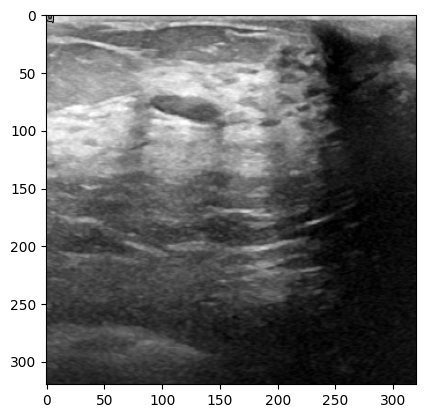

In [30]:
plt.imshow(x_test[19,:,:,:])
print(y_test[19])
print(y_pred[19])

In [31]:
# model.evaluate(x_test,y_test)

# In general sgd is slow but works well and is less probable to overfit . Adam is faster in result but is more likely to overfit